Signal per region type plotted


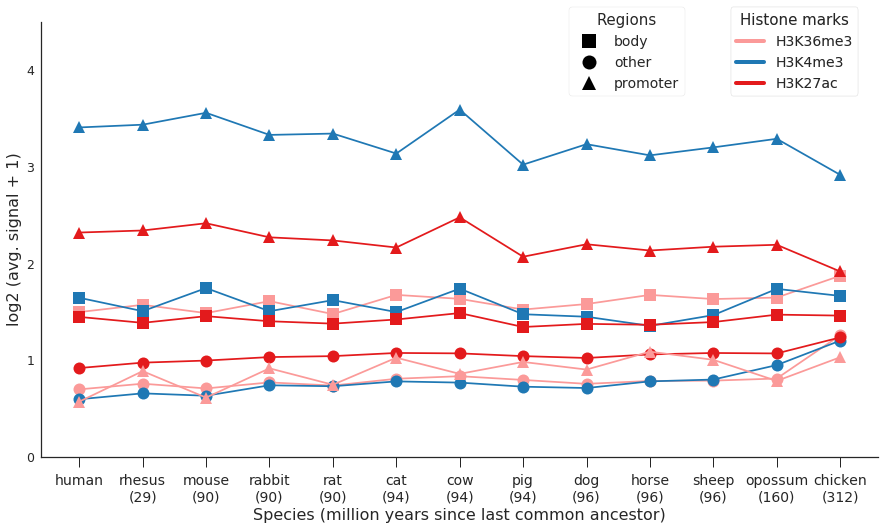

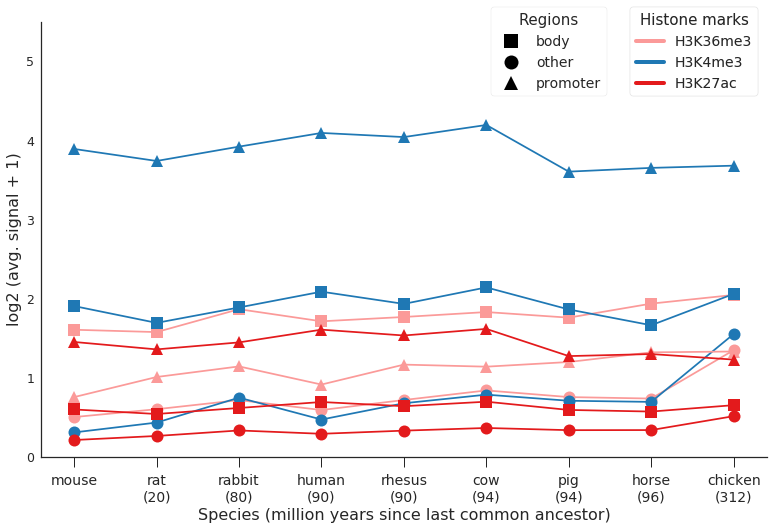

In [2]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import numpy.ma as msk
import json as js
import time as ti
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn
import itertools as itt

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_1samp as tt


date = '20180512'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

source_sig_cache = os.path.join(os.path.split(cache_dir)[0], 'pipe_scripts', '{}_cache_source_signal.h5'.format(date))
transfer_sig_cache = os.path.join(os.path.split(cache_dir)[0], 'pipe_scripts', '{}_cache_transfer_signal.h5'.format(date))

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
spec_lut = plot_colors['mapping']
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

use_assemblies = set()
for k, v in spec_lut.items():
    try:
        use_assemblies.add(v['assembly'])
    except KeyError:
        continue
use_assemblies -= set(['anoCar2', 'xenTro3'])


out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
diss_folder = '/home/pebert/work/code/mpggit/dissertation/Figures'
run_exec_region_signal = True
save_figures = True
save_diss = True

color_k4 = tuple(x / 255 for x in [31,120,180])
color_k27 = tuple(x / 255 for x in [227,26,28])
color_k36 = tuple(x / 255 for x in [251,154,153])


def exec_region_signal():
    species, lca = read_references(species_file, lca_times_file)
    cache_file = os.path.join(cache_dir, '{}_plot_region_signal.pck'.format(date))
    if not os.path.isfile(cache_file):
        avg_signal = collect_region_signal(spec_lut, lca)
        with open(cache_file, 'wb') as cache:
            pck.dump(avg_signal, cache)
    else:
        with open(cache_file, 'rb') as cache:
            avg_signal = pck.load(cache)
    
    hist_colors = {'H3K4me3': color_k4, 'H3K36me3': color_k36, 'H3K27ac': color_k27}
    reg_shapes = {'promoter': '^', 'body': 's', 'other': 'o'}
    z_order = {'promoter': 3, 'body': 2, 'other': 1}
    
    for fkey, ref in zip(['S3A', 'S3B'], ['human', 'mouse']):
        title = fkey
        fig, exart = plot_region_signal(ref, avg_signal, hist_colors,
                                        reg_shapes, z_order, title, save_diss)
        if save_figures:
            outname = 'fig_{}_region_signal'.format(fkey)
            if not save_diss:
                subfolder = 'supp'
            else:
                subfolder = 'crossspecies'
                out_folder = diss_folder
                
            if not save_diss:
                outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

                outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
    return True


def plot_region_signal(ref_spec, sigdata, color_lut, shape_lut, zorder, title, save_diss=False):
    
    if ref_spec == 'human':
        fig, ax = plt.subplots(figsize=(15, 8))
    else:
        fig, ax = plt.subplots(figsize=(13, 8))
        
    max_y = 0
    
    keys_by_dist = sorted(sigdata.keys())
    x_labels = []
    for region, shape in shape_lut.items():
        for mark, color in color_lut.items():
            key_filter = lambda x: x[1] == ref_spec and x[3] == region and x[4] == mark and x[5] == 'mean'
            x_labels = ['{}\n({})'.format(k[2], k[0]) for k in filter(key_filter, keys_by_dist)]
            x_labels[0] = ref_spec
            
            data = [sigdata[k] for k in filter(key_filter, keys_by_dist)]
            
            y_vals = np.log2(np.array(list(map(np.mean, data)), dtype=np.float32) + 1)
            x_vals = np.arange(0.5, y_vals.size , 1)
            
            max_y = y_vals.max() if y_vals.max() > max_y else max_y
            
            z = zorder[region]
            ax.plot(x_vals, y_vals, color=color,
                    marker=shape, markersize=12,
                    zorder=z, label='{} {}'.format(mark, region))
    
    max_y = np.ceil(max_y)
    ax.set_ylim(0, max_y + 0.5)
    
    ax.set_yticks(np.arange(0, max_y + 1, 1))
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels, fontsize=14)
    
    ax.tick_params(axis='x', direction='out', length=10)
    
    handles_shape = []
    for l, s in shape_lut.items():
        handles_shape.append(plt.Line2D([], [], marker=s, linestyle='',
                                        label=l, c='black'))
        
    handles_color = []
    for l, c in color_lut.items():
        handles_color.append(plt.Line2D([], [], linestyle='solid',
                                        linewidth=4, label=l, c=c))
        
    leg_shape = plt.legend(handles=handles_shape, loc='upper center',
                           title='Regions', markerscale=2, ncol=1,
                           fontsize=14, frameon=True)
    
    leg_color = plt.legend(handles=handles_color, loc='upper center',
                           title='Histone marks', ncol=1,
                           fontsize=14, frameon=True)
    
    art_shape = ax.add_artist(leg_shape)
    art_color = ax.add_artist(leg_color)
    
    art_shape.set_bbox_to_anchor((0.7, 1.05))
    art_color.set_bbox_to_anchor((0.9, 1.05))
                
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if not save_diss:
        tt = ax.set_title(title, fontsize=18)
        tt.set_position([0.02, 1.02])
    
    ax.set_xlabel('Species (million years since last common ancestor)', fontsize=16)
    ax.set_ylabel('log2 (avg. signal + 1)', fontsize=16)
 
    if not save_diss:
        exart = [leg_shape, leg_color, tt]
    else:
        exart = [leg_shape, leg_color]
    
    return fig, exart


def collect_region_signal(species, lca_dist):
    sig_collector = col.defaultdict(list)
    with pd.HDFStore(source_sig_cache, 'r') as hdf:
        for k in hdf.keys():
            # '/hg19/body/H3K36me3/chr9'
            _, trg, region, mark, _ = k.split('/')
            spec = species[trg]['species']
            data = hdf[k]
            sig_collector[(0, spec, spec, region, mark, 'mean')].append(data.mean())
            sig_collector[(0, spec, spec, region, mark, 'std')].append(data.std())
    
    with pd.HDFStore(transfer_sig_cache, 'r') as hdf:
        for k in hdf.keys():
            # /mm9/susScr2/promoter/H3K27ac/chr1
            _, trg, qry, region, mark, _ = k.split('/')
            trg_spec = species[trg]['species']
            qry_spec = species[qry]['species']
            dist = lca_dist[(trg_spec, qry_spec)]
            data = hdf[k]
            sig_collector[(dist, trg_spec, qry_spec, region, mark, 'mean')].append(data.mean())
            sig_collector[(dist, trg_spec, qry_spec, region, mark, 'std')].append(data.std())

    return sig_collector


def read_references(species, lca):
    
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist


if run_exec_region_signal:
    execd = exec_region_signal()
    print('Signal per region type plotted')
